In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mofapy2.run.entry_point import entry_point
import mofax

In [ ]:
def generate_dot_plot(pval_df, score_df, significance=0.05, xlabel='', ylabel='', cbar_title='Score', cmap='PuOr',
                      figsize=(16, 9), label_size=20, title_size=20, tick_size=14, filename=None):
    '''Generates a dot plot for given P-values and respective scores.
    Parameters
    ----------
    pval_df : pandas.DataFrame
        A dataframe containing the P-values, with multiple elements
        in both rows and columns
    score_df : pandas.DataFrame
        A dataframe containing the scores that were tested. Rows and
        columns must be the same as in `pval_df`.
    significance : float, default=0.05
        The significance threshold to be plotted. LR pairs or cell-cell
        pairs with at least one P-value below this threshold will be
        considered.
    xlabel : str, default=''
        Name or label of the X axis.
    ylabel : str, default=''
        Name or label of the Y axis.
    cbar_title : str, default='Score'
        A title for the colorbar associated with the scores in
        `score_df`. It is usually the name of the score.
    cmap : str, default='PuOr'
        A matplotlib color palette name.
    figsize : tuple, default=(16, 9)
        Size of the figure (width*height), each in inches.
    label_size : int, default=20
        Specifies the size of the labels of both X and Y axes.
    title_size : int, default=20
        Specifies the size of the title of the colorbar and P-val sizes.
    tick_size : int, default=14
        Specifies the size of ticklabels as well as the maximum size
        of the dots.
    filename : str, default=None
        Path to save the figure of the elbow analysis. If None, the figure is not
        saved.
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object made with matplotlib
    '''
    # Reorder the dataframes according to the custom pathway order
    # Preprocessing
    df = pval_df.lt(significance).astype(int)
    # Drop all zeros
    df = df.loc[(df != 0).any(axis=1)]
    df = df.T.loc[(df != 0).any(axis=0)].T
    pval_df = pval_df[df.columns].loc[df.index].applymap(lambda x: -1. * np.log10(x + 1e-9))

    # Set dot sizes and color range
    max_abs = np.max([np.abs(np.min(np.min(score_df))), np.abs(np.max(np.max(score_df)))])
    norm = mpl.colors.Normalize(vmin=-1. * max_abs, vmax=max_abs)
    max_size = mpl.colors.Normalize(vmin=0, vmax=9)

    # Colormap
    cmap = mpl.cm.get_cmap(cmap)

    # Dot plot
    #mpl.style.use('seaborn-white')
    fig, (ax2, ax) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 9]})
    for i, idx in enumerate(pval_df.index):
        for j, col in enumerate(pval_df.columns):
            color = np.asarray(cmap(norm(score_df[[col]].loc[[idx]].values.item()))).reshape(1, -1)
            size = (max_size(pval_df[[col]].loc[[idx]].values.max()) * tick_size * 2) ** 2
            ax.scatter(j, i, s=size, c=color)


    # Change tick labels
    xlabels = list(pval_df.columns)
    ylabels = list(pval_df.index)
    ax.grid(True)
    ax.set_xticks(ticks=range(0, len(pval_df.columns)))
    ax.set_xticklabels(xlabels,
                       fontsize=tick_size,
                       rotation=90,
                       rotation_mode='anchor',
                       va='center',
                       ha='right')

    ax.set_yticks(ticks=range(0, len(pval_df.index)))
    ax.set_yticklabels(ylabels,
                       fontsize=tick_size,
                       rotation=0, ha='right', va='center'
                       )

    plt.gca().invert_yaxis()

    plt.tick_params(axis='both',
                    which='both',
                    bottom=True,
                    top=False,
                    right=False,
                    left=True,
                    labelleft=True,
                    labelbottom=True)
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)

    # Colorbar
    # create an axes on the top side of ax. The width of cax will be 3%
    # of ax and the padding between cax and ax will be fixed at 0.21 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="3%", pad=0.21)

    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cax,
                        orientation='horizontal'
                        )
    cbar.ax.tick_params(labelsize=tick_size)

    cax.tick_params(axis='x',  # changes apply to the x-axis
                    which='both',  # both major and minor ticks are affected
                    bottom=False,  # ticks along the bottom edge are off
                    top=True,  # ticks along the top edge are off
                    labelbottom=False,  # labels along the bottom edge are off
                    labeltop=True
                    )
    cax.set_title(cbar_title, fontsize=title_size)

    for i, v in enumerate([np.min(np.min(pval_df)), -1. * np.log10(significance + 1e-9), 3.0]):
        ax2.scatter(i, 0, s=(max_size(v) * tick_size * 2) ** 2, c='k')
        ax2.scatter(i, 1, s=0, c='k')
        if v == 3.0:
            extra = '>='
        elif i == 1:
            extra = 'Threshold: '
        else:
            extra = ''
        ax2.annotate(extra + str(np.round(abs(v), 4)), (i, 1), fontsize=tick_size, horizontalalignment='center')
    ax2.set_ylim(-0.5, 2)
    ax2.axis('off')
    ax2.set_title('-log10(P-value) sizes', fontsize=title_size)
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    return 

In [59]:
library_id = 'pkd_1'

In [87]:
output_dir = f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/{library_id}_25factors/'

In [88]:
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [89]:
adata_st = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/h5ad/spatial_processed.h5ad")
adata_st = adata_st[adata_st.obs.library_id == library_id].copy()

In [90]:
adata_st

AnnData object with n_obs × n_vars = 1872 × 17628
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'clusters', 'clusters_0.7', 'S_score', 'G2M_score', 'phase', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'clusters_colors', 'dendrogram_clusters_0.7', 'hvg', 'leiden', 'library_id_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'LogNorm', 'scaled'
    obsp: 'connectivities', 'distances'

In [91]:
adata_st.X = adata_st.layers['LogNorm']

In [92]:
adata_st.obs = pd.concat([adata_st.obs, 
                       pd.DataFrame(adata_st.obsm["spatial"], columns=["imagerow", "imagecol"], index=adata_st.obs_names),
                      ], axis=1)

## Train MEFISTO

In [93]:
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [94]:
ent.set_data_options(use_float32=True)

use_float32 set to True: replacing float64 arrays by float32 arrays to speed up computations...



In [95]:
ent.set_data_from_anndata(adata_st, features_subset="highly_variable")

Loaded view='rna' group='group1' with N=1872 samples and D=2000 features...





In [96]:
ent.set_model_options(factors=25)
ent.set_train_options()

Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (rna): gaussian




In [98]:
# We use 1000 inducing points to learn spatial covariance patterns
n_inducing = 1000

ent.set_covariates([adata_st.obsm["spatial"]], covariates_names=["imagerow", "imagecol"])
ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing/adata_st.n_obs,
                       start_opt=10, opt_freq=10)

Loaded 2 covariate(s) for each sample...


##
## sparseGP set to True: using sparse Gaussian Process to speed up the training procedure
##


In [99]:
ent.build()
ent.run()
ent.save(output_dir + f"{library_id}_MEFISTO_model.hdf5")



######################################
## Training the model with seed 888 ##
######################################


ELBO before training: -55705088.85 

Iteration 1: time=4.04, ELBO=2419462.35, deltaELBO=58124551.201 (104.34334169%), Factors=25
Iteration 2: time=4.07, ELBO=2986834.13, deltaELBO=567371.780 (1.01852773%), Factors=25
Iteration 3: time=4.16, ELBO=3041857.14, deltaELBO=55023.012 (0.09877556%), Factors=25
Iteration 4: time=4.05, ELBO=3058666.67, deltaELBO=16809.530 (0.03017593%), Factors=25
Iteration 5: time=4.09, ELBO=3067550.13, deltaELBO=8883.460 (0.01594730%), Factors=25
Iteration 6: time=3.81, ELBO=3073515.78, deltaELBO=5965.648 (0.01070934%), Factors=25
Iteration 7: time=4.16, ELBO=3077458.91, deltaELBO=3943.135 (0.00707859%), Factors=25
Iteration 8: time=4.06, ELBO=3079970.15, deltaELBO=2511.233 (0.00450809%), Factors=25
Iteration 9: time=3.75, ELBO=3081863.38, deltaELBO=1893.237 (0.00339868%), Factors=25
Optimising sigma node...
Iteration 10: time=154.48, ELBO=3

## Downstream analysis

In [316]:
library_id = 'Control'

In [317]:
output_dir = f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/{library_id}/'

In [290]:
m = mofax.mofa_model(output_dir + f"Model/{library_id}_MEFISTO_model.hdf5")

In [107]:
m.get_factors(df=True).to_csv(output_dir + f"{library_id}_MEFISTO_factors_barcodes.csv", sep=',')

In [318]:
top_f = m.get_top_features(df=True, n_features=2000)
top_f.drop(columns=['view', 'index'], inplace=True)

In [108]:
top_f = m.get_top_features(df=True, n_features=2000, )
top_f.drop(columns=['view', 'index'], inplace=True)
top_f.to_excel(output_dir + f"{library_id}_all_features.xlsx")

In [109]:
m.get_weights(df=True).to_excel(output_dir + f"{library_id}_mefisto_factors.xlsx")

In [110]:
factor_features = m.get_weights(df=True)

In [111]:
for column in factor_features.columns:
    df = factor_features[column].copy()
    df.sort_values(ascending=False).to_frame().to_csv(output_dir + f"{library_id}_{column}" + '.rnk', header=None)

In [18]:
factor_features

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,...,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25
Sox17,4.902651e-03,0.000033,0.001403,0.001583,-1.605930e-05,0.000180,0.010036,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sulf1,-1.740632e-03,0.000110,0.003881,0.000018,-1.481361e-04,0.006655,0.010322,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sbspon,1.091790e-03,-0.000007,-0.000012,0.011519,1.925501e-02,-0.003485,-0.000010,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tfap2b,2.310683e-02,0.019507,0.019619,-0.008373,-3.095820e-05,-0.006477,-0.008398,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm26788,-1.459110e-07,-0.000004,-0.000003,-0.000006,-8.959820e-08,0.000001,0.000002,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vegfd,4.471410e-03,0.017659,0.019434,-0.006184,-3.748292e-05,0.007503,0.000482,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Egfl6,2.813231e-02,0.000044,0.000584,0.001449,-1.448428e-03,-0.000092,-0.004067,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tmsb4x,7.764648e-02,0.043264,0.067143,0.033122,6.924836e-02,0.045619,0.098642,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mt-Co1,-1.512041e-02,0.013146,0.043572,0.017559,-7.362836e-02,-0.016361,-0.044201,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
df_loadings = pd.concat([pd.read_csv(f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/{library_id}/{library_id}_MEFISTO_factors_barcodes.csv', 
                            sep=',', index_col=0) for library_id in ['Control','pkd_1', 'pkd_2', 'pkd_3']])

In [213]:
library_id = 'pkd_3'

In [214]:
adata_st = sc.read_h5ad("/exports/humgen/cnovellarausell/SevtapSpatial/h5ad/spatial_processed.h5ad")
adata_st.obs = adata_st.obs.join(df_loadings)
adata_st = adata_st[adata_st.obs.library_id == library_id].copy()

In [ ]:
# Plot the spatial data
axs = sc.pl.spatial(
    adata_st, 
    img_key="hires", 
    color=[f"Factor{i+1}" for i in range(25)], 
    show=False, 
    library_id=library_id, 
    frameon=False, 
    cmap='coolwarm', 
    alpha_img=0.1,
    vcenter=0
)

# Set the number of ticks you want, for example, 5 ticks
num_ticks = 4

# Iterate over the axes and set ticks for each colorbar
for ax in axs:
    cbar = ax.collections[-1].colorbar  # Access the colorbar for each subplot

    # Get the limits (min and max) for each colorbar
    cbar_min, cbar_max = cbar.vmin, cbar.vmax

    # Create a uniform tick range based on the data range of each colorbar
    ticks = np.linspace(cbar_min, cbar_max, num_ticks)

    # Set the new ticks on the colorbar
    cbar.set_ticks(ticks)
    # Set the colorbar title (label)
    cbar.set_label("Factor loading")

# Save the figure as a PDF to ensure text is editable
plt.savefig(f"/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/spot_weights_patterns_{library_id}_sameticknumbers.pdf", bbox_inches='tight', format='pdf')
# Show the plot with updated ticks
plt.show()

## Visualize correlations

In [3]:
top_features_Control = pd.read_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/Control/Control_all_features.xlsx")
top_features_pkd1 = pd.read_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/pkd_1/pkd_1_top_features.xlsx")
top_features_pkd2 = pd.read_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/pkd_2/pkd_2_all_features.xlsx")
top_features_pkd3 = pd.read_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/pkd_3/pkd_3_all_features.xlsx")

In [5]:
top_features_Control['library'] = 'Control'
top_features_pkd1['library'] = 'pkd1'
top_features_pkd2['library'] = 'pkd2'
top_features_pkd3['library'] = 'pkd3'

df_all = pd.concat([top_features_Control, top_features_pkd1, top_features_pkd2, top_features_pkd3], ignore_index=True)
df_all_wide = df_all.pivot(
    index='feature', 
    columns=['library','factor'], 
    values='value'
)

In [23]:
corrs = df_all_wide.corr(method='pearson')

In [ ]:
corrs_no_nan = (
    corrs
    .dropna(axis=0, how="all")  # Drop rows that are all NaN
    .dropna(axis=1, how="all")  # Drop columns that are all NaN
)
corrs_no_nan.values[np.diag_indices_from(corrs_no_nan)] = np.nan


import re

def get_factor_number(factor_str):
    """
    Given a factor string like 'Factor12',
    return the integer 12.
    If no digits found, return 999999 so it sorts to the bottom.
    """
    match = re.search(r'\d+$', factor_str)
    if match:
        return int(match.group())
    else:
        return 999999

row_index_df = pd.DataFrame(index=corrs_no_nan.index).reset_index()
row_index_df['factor_num'] = row_index_df['factor'].apply(get_factor_number)
row_index_df = row_index_df.sort_values(['library', 'factor_num'])
new_row_index = list(zip(row_index_df['library'], row_index_df['factor']))
corrs_no_nan = corrs_no_nan.reindex(index=new_row_index)
col_index_df = pd.DataFrame(index=corrs_no_nan.columns).reset_index()
col_index_df['factor_num'] = col_index_df['factor'].apply(get_factor_number)
col_index_df = col_index_df.sort_values(['library', 'factor_num'])
new_col_index = list(zip(col_index_df['library'], col_index_df['factor']))
corrs_no_nan = corrs_no_nan.reindex(columns=new_col_index)

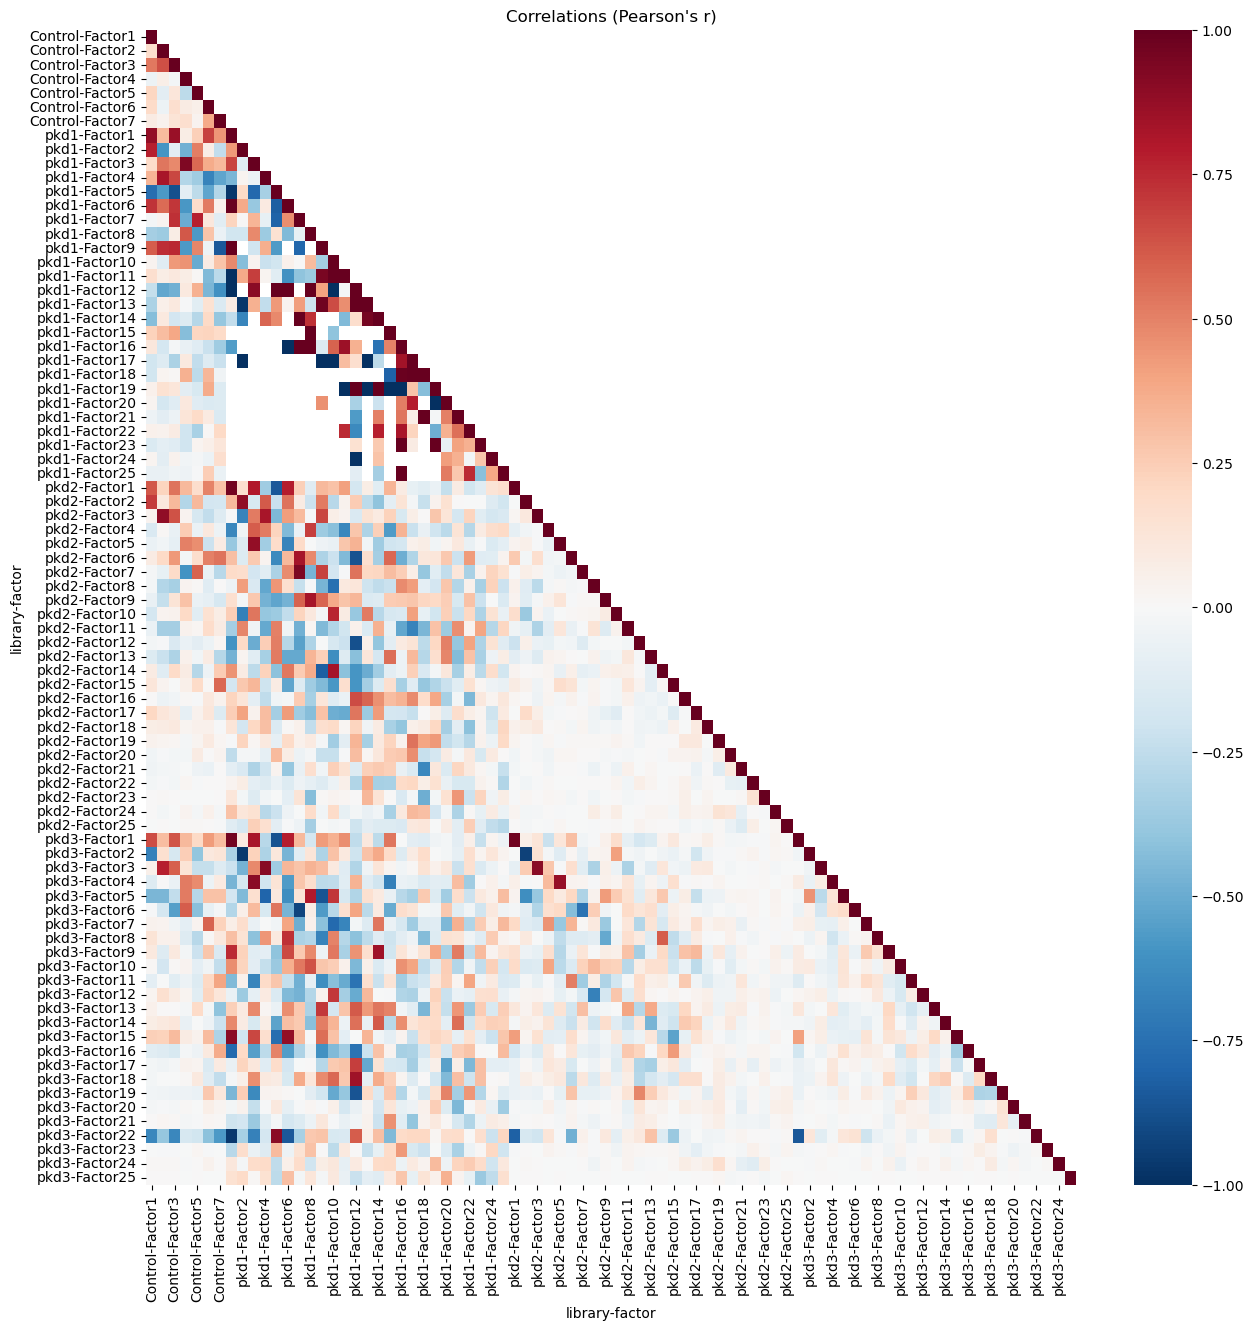

In [26]:
plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(corrs_no_nan, dtype=bool), k=1)

ax = sns.heatmap(corrs_no_nan, cmap='RdBu_r', center=0, mask=mask)
plt.title("Correlations (Pearson's r)")
#plt.savefig("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/correlations_factors.pdf", bbox_inches='tight')
plt.show()

In [ ]:
corrs_wo_control = corrs_no_nan.drop(index='Control', level='library', errors='ignore')

corrs_wo_control = corrs_wo_control.drop(columns='Control', level='library', errors='ignore')

In [ ]:
import pandas as pd

best_matches = []

row_labels = corrs_no_nan.index  

for row_label in row_labels:
    row_lib, row_factor = row_label  
    
    row_values = corrs_no_nan.loc[row_label]

    if row_label in row_values.index:
        row_values = row_values.drop(row_label, errors='ignore')
    same_lib_mask = row_values.index.get_level_values('library') == row_lib
    row_values = row_values[~same_lib_mask]  # keep columns where library != row_lib
    

    
    grouped = row_values.groupby(level='library')

    row_dict = {
        'row_library': row_lib,
        'row_factor': row_factor
    }
    
    for col_lib, sub_series in grouped:
        max_col_label = sub_series.idxmax()  # e.g. ('pkd3', 'Factor3')
        max_corr = sub_series[max_col_label]

        best_factor = max_col_label[1]
        
        row_dict[f'{col_lib}_best_factor'] = best_factor
        row_dict[f'{col_lib}_corr'] = max_corr
    
    best_matches.append(row_dict)

# Convert to a DataFrame
best_matches_df = pd.DataFrame(best_matches)


,row_library,row_factor,pkd1_best_factor,pkd1_corr,pkd2_best_factor,pkd2_corr,pkd3_best_factor,pkd3_corr,Control_best_factor,Control_corr
0,Control,Factor1,Factor1,0.534122,Factor2,0.697784,Factor1,0.652145,NaN,NaN
1,Control,Factor2,Factor4,0.525566,Factor3,0.885148,Factor3,0.777045,NaN,NaN
2,Control,Factor3,Factor1,0.459000,Factor3,0.640364,Factor1,0.628425,NaN,NaN
3,Control,Factor4,Factor3,0.539741,Factor5,0.502410,Factor6,0.605570,NaN,NaN
4,Control,Factor5,Factor7,0.364194,Factor7,0.592867,Factor4,0.475262,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
77,pkd3,Factor21,Factor15,0.042260,Factor12,0.085478,NaN,NaN,Factor6,0.022161
78,pkd3,Factor22,Factor5,0.387794,Factor13,0.295430,NaN,NaN,Factor4,-0.164366
79,pkd3,Factor23,Factor24,0.069506,Factor22,0.048724,NaN,NaN,Factor5,0.019393
80,pkd3,Factor24,Factor22,0.084087,Factor19,0.167069,NaN,NaN,Factor6,0.039312


In [147]:
best_matches_df.to_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/matched_factors.xlsx")

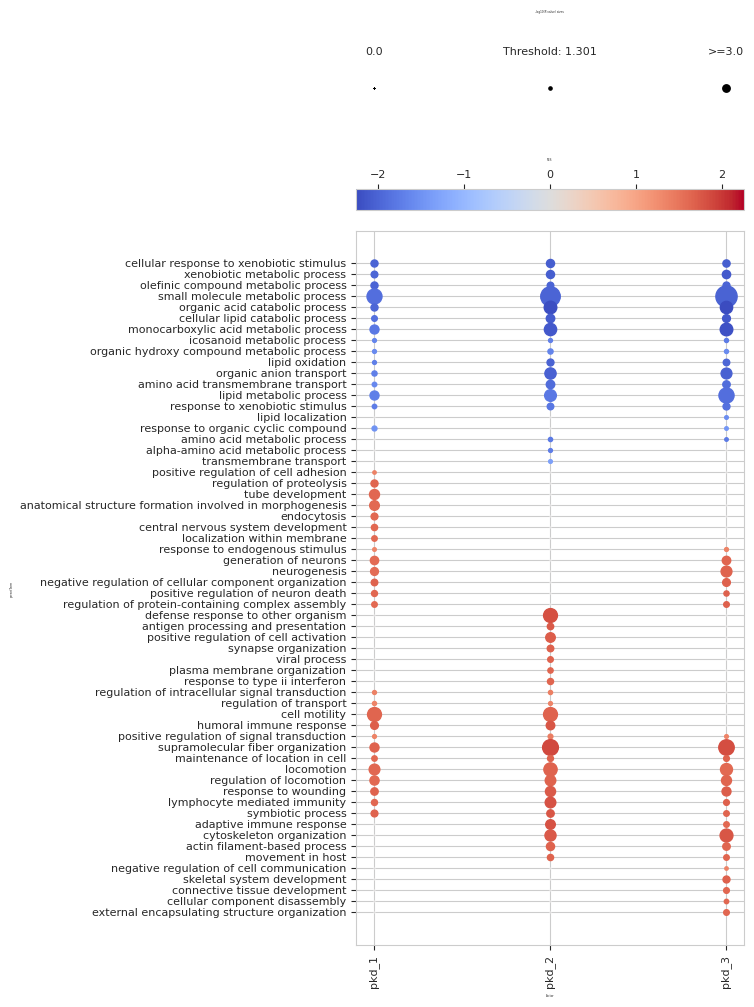

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
df = pd.concat([pd.read_csv(f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/{library_id}/GSEA_GO_BiologicalProcesses/{library_id}_Factor1_GSEA.tsv', 
                            sep='\t').assign(library_id=str(library_id)) for library_id in ['pkd_1', 'pkd_2', 'pkd_3']])

mappings = pd.read_csv("/exports/humgen/cnovellarausell/SevtapSpatial/gmts/MSigDB_GO_Terms.txt", sep='\t')
mappings = mappings[mappings.MSigDB_Set_Name.str.startswith('GOBP_')].copy()
mappings.MSigDB_Set_Name = mappings.MSigDB_Set_Name.str.split('_').str[1:].str.join(' ')
mappings.index = mappings.MSigDB_Set_Name

mappings.index = 'GOBP_' + mappings.index.str.replace(' ', '_')

df['go_id'] = df.pathway.map(mappings.GO_Term_ID)

parent_terms = pd.read_csv("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Factor1_GSEA_reduced.tsv",  sep='\t')

df.set_index('go_id', inplace=True)
df['parentTerm'] = parent_terms['parentTerm']
df.reset_index(inplace=True)
df.parentTerm.fillna(df.pathway, inplace=True)
unique_library_ids = df['library_id'].unique()
frames = []  # To hold the filtered dataframes.

for library_id in unique_library_ids:
    sub_df = df[df['library_id'] == library_id]
    sub_df.sort_values(by='padj', ascending=True, inplace=True)
    sub_df.drop_duplicates(subset='parentTerm', keep='first', inplace=True)
    frames.append(sub_df)

# Concatenate all the filtered dataframes.
df = pd.concat(frames)

def convert_to_lowercase(text):
    if text.startswith("GOBP_"):
        return ' '.join(text[5:].lower().split('_'))
    return text

# Apply the function to the 'parentTerm' column.
df['parentTerm'] = df['parentTerm'].apply(convert_to_lowercase)


# Filter out rows with 'nan' values in the 'adj P-val' column
df = df.loc[df['padj'] != 'nan']
# Convert the 'adj P-val' and 'NES' columns to numeric type
df['padj'] = pd.to_numeric(df['padj'])
df['NES'] = pd.to_numeric(df['NES'])

# Remove duplicate rows
df.drop_duplicates(inplace=True)
df = df[df.padj < 0.05].copy()
pathway_leadingEdge = dict(zip(df.pathway, df.leadingEdge))

filtered_dfs = []
for library in df['library_id'].unique():
    library_df = df[df['library_id'] == library]
    top_high = library_df.nlargest(20, 'NES')
    top_low = library_df.nsmallest(20, 'NES')
    filtered_dfs.append(pd.concat([top_high, top_low]))
final_df = pd.concat(filtered_dfs)

df_pivot = final_df.pivot(index="parentTerm", columns="library_id", values="padj").fillna(1.)
scores = final_df.pivot(index="parentTerm", columns="library_id", values="NES").fillna(0)

row_distances = pdist(scores.values, metric='euclidean')  # or 'correlation', etc.

Z = linkage(row_distances, method='ward')  # or 'average', 'complete', etc.

row_leaves = leaves_list(Z)

df_pivot_clustered = df_pivot.iloc[row_leaves]
scores_clustered   = scores.iloc[row_leaves]

# Now call your plotting function with the clustered data
with sns.axes_style("whitegrid"):
    dotplot = generate_dot_plot(
        pval_df=df_pivot_clustered,
        score_df=scores_clustered,
        significance=0.05,
        xlabel='Factor',
        ylabel='parentTerm',
        cbar_title='NES',
        cmap='coolwarm',
        figsize=(5,12),
        label_size=2,
        title_size=2,
        tick_size=8,
        filename=f'/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/Factor1_pkd1_pkd2_pkd3_top20NES_GOBP_25%REVIGO_clusteredbyNES.pdf'
    )

In [145]:
top_features_Control = pd.read_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/Control/Control_all_features.xlsx")
top_features_pkd1 = pd.read_excel("/exports/humgen/cnovellarausell/mefisto_pkd_1/top_2000_features_25_factors.xlsx")
top_features_pkd2 = pd.read_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/pkd_2/pkd_2_all_features.xlsx")
top_features_pkd3 = pd.read_excel("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/pkd_3/pkd_3_all_features.xlsx")

In [146]:
top_features_Control =  top_features_Control[top_features_Control.factor == 'Factor1']
top_features_pkd1 = top_features_pkd1[top_features_pkd1.factor == 'Factor1']
top_features_pkd2 = top_features_pkd2[top_features_pkd2.factor == 'Factor1']
top_features_pkd3 = top_features_pkd3[top_features_pkd3.factor == 'Factor1']

In [ ]:
# Extract top 10 positive and negative genes for each sample
def top_genes(df):
    top_pos = df.nlargest(10, 'value')  # replace 'weight' with the actual column name for weight
    top_neg = df.nsmallest(10, 'value')  # replace 'weight' with the actual column name for weight
    return pd.concat([top_pos, top_neg])

top_Control = top_genes(top_features_Control)
top_pkd1 = top_genes(top_features_pkd1)
top_pkd2 = top_genes(top_features_pkd2)
top_pkd3 = top_genes(top_features_pkd3)

combined_df = pd.concat([top_Control.assign(sample='Control'),
                         top_pkd1.assign(sample='pkd1'), 
                         top_pkd2.assign(sample='pkd2'), 
                         top_pkd3.assign(sample='pkd3')])

pivot_df = combined_df.pivot_table(index='feature', columns='sample', values='value')  # replace 'gene' and 'weight' with actual column names

In [135]:
pivot_df.fillna(0, inplace=True)

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list
row_distances = pdist(pivot_df.values, metric='euclidean')  # or "correlation"

Z = linkage(row_distances, method='average')  # or "ward", "complete", etc.

row_leaves = leaves_list(Z)

pivot_df_clustered = pivot_df.iloc[row_leaves]

In [ ]:
pkd_cols = ['pkd1', 'pkd2', 'pkd3']
df_to_plot = pivot_df_clustered.copy()
mask_pkd_notnan = df_to_plot[pkd_cols].notna().all(axis=1)

mask_pkd_positive = mask_pkd_notnan & (df_to_plot[pkd_cols] > 0).all(axis=1)
mask_pkd_negative = mask_pkd_notnan & (df_to_plot[pkd_cols] < 0).all(axis=1)


mask_control_notnan = df_to_plot['Control'].notna()
mask_control_positive = mask_control_notnan & (df_to_plot['Control'] > 0)
mask_control_negative = mask_control_notnan & (df_to_plot['Control'] < 0)


# Genes consistently pkd => set Control to NaN
df_to_plot.loc[mask_pkd_positive | mask_pkd_negative, 'Control'] = np.nan

# Genes consistently Control => set pkd columns to NaN
df_to_plot.loc[mask_control_positive | mask_control_negative, pkd_cols] = np.nan


mask_in_pkd = (mask_pkd_positive | mask_pkd_negative)
mask_in_control = (mask_control_positive | mask_control_negative)

mask_keep = mask_in_pkd | mask_in_control

df_to_plot = df_to_plot[mask_keep].copy()
df_to_plot.dropna(how='all', inplace=True)

In [ ]:
df_to_plot.fillna(0, inplace=True)
row_distances = pdist(df_to_plot.values, metric='euclidean')  # or "correlation"

Z = linkage(row_distances, method='average')  # or "ward", "complete", etc.

row_leaves = leaves_list(Z)

df_to_plot_clustered = df_to_plot.iloc[row_leaves]
df_to_plot_clustered.replace(0, np.nan, inplace=True)

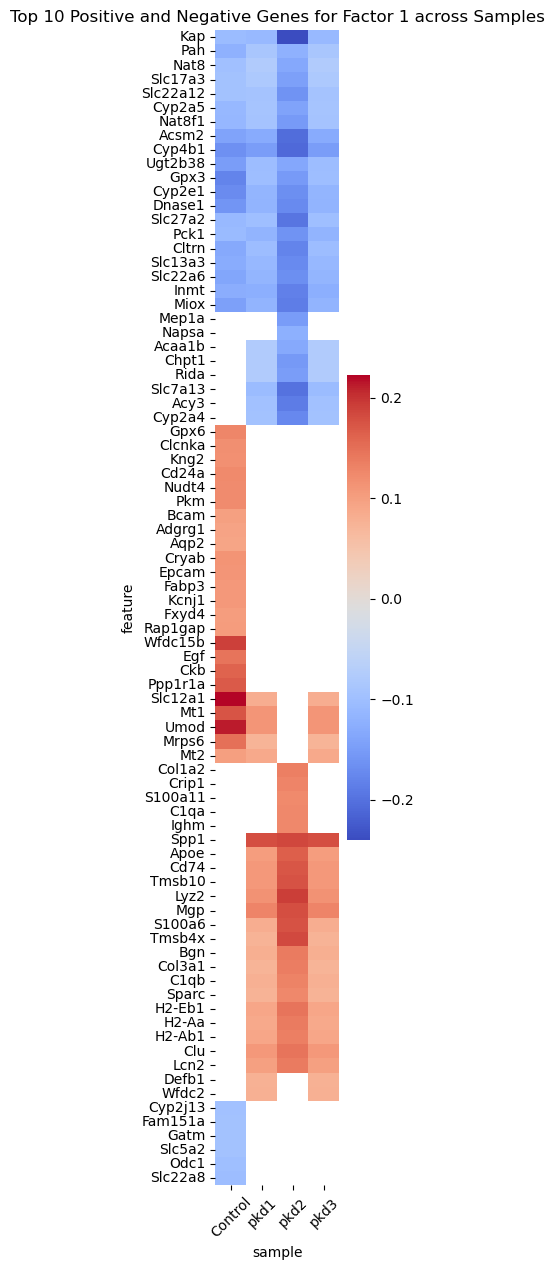

In [ ]:
plt.figure(figsize=(2,15))
pivot_df_clustered.replace(0, np.nan, inplace=True)
sns.heatmap(pivot_df_clustered, cmap='coolwarm', )  # adjust formatting as needed
plt.title('Top 10 Positive and Negative Genes for Factor 1 across Samples')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
#plt.savefig("/exports/archive/hg-groep-peters/Spatial_Transcriptomics_Snowball_Sevtap/Figures_without_unknown_cluster/Unsupervised_spatial_patterns/gene_weights_factor1_all_kidneys_top10_clusteredrows.pdf", bbox_inches='tight')
plt.show()